## Random Forest Regession Implementation step by step

Most of the code is copied and modifed from the different implementations in Notes.ipynb, take aways from the previous version that needs chaning implementation to t+24h forcast instead of t+6h. This along with energy data is seen as "true" meaning it cannot be used for training and testing straight away. Instead you would need to have it as a seperate target which sounds like a headace because boa is affected by the market and I'm not even going to attempt. Regardless something simple coud be tested to be implemented but only if time is avalible.

In [1]:
# Import Libraries and preprocces data
import numpy as np
import pandas as pd
import xarray as xr

from datetime import timedelta

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

model_table = pd.read_csv("data/forecast_data_merged_2.csv")
# convert to datetime
model_table["ref_datetime"] = pd.to_datetime(model_table["ref_datetime"])
model_table["valid_datetime"] = pd.to_datetime(model_table["valid_datetime"])

In [2]:
# Drop the True values
columns_to_remove = ["dtm", "Solar_MW", "Wind_MW", 
                    "wind_curtailment_MW", "wind_potential_MW", 
                    "Solar_MWh_credit", "Wind_MWh_credit",
                    "total_generation_MWh"]

model_table = model_table.drop(columns_to_remove, axis=1)
display(model_table)

,ref_datetime,valid_datetime,dwd_RelativeHumidity,dwd_WindDirection_100,dwd_WindSpeed_100,dwd_CloudCover,dwd_SolarDownwardRadiation,dwd_Temperature,ncep_RelativeHumidity,ncep_WindDirection_100,ncep_WindSpeed_100,ncep_CloudCover,ncep_SolarDownwardRadiation,ncep_Temperature
0,2020-09-20 00:00:00+00:00,2020-09-20 00:00:00+00:00,85.213750,62.085170,11.802604,0.450405,0.000000,13.646173,84.066666,58.721077,11.338991,0.026000,0.0,13.940016
1,2020-09-20 00:00:00+00:00,2020-09-20 00:30:00+00:00,85.012270,61.726974,11.648818,0.472211,0.000000,13.658508,84.433334,58.494644,11.516161,0.039000,0.0,13.896579
2,2020-09-20 00:00:00+00:00,2020-09-20 01:00:00+00:00,84.810780,61.368782,11.495032,0.494018,0.000000,13.670843,84.800000,58.268215,11.693331,0.052000,0.0,13.853142
3,2020-09-20 00:00:00+00:00,2020-09-20 01:30:00+00:00,84.357895,61.111046,11.354128,0.520214,0.000000,13.732101,84.933334,59.550636,11.716686,0.038500,0.0,13.847113
4,2020-09-20 00:00:00+00:00,2020-09-20 02:00:00+00:00,83.905000,60.853313,11.213223,0.546410,0.000000,13.793360,85.066666,60.833060,11.740043,0.025000,0.0,13.841084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452755,2023-10-27 00:00:00+00:00,2023-10-27 21:30:00+00:00,80.259060,177.495090,2.620757,0.549926,-0.003020,8.741467,81.200000,203.196010,5.695431,0.144725,0.0,8.939343
452756,2023-10-27 00:00:00+00:00,2023-10-27 22:00:00+00:00,79.186960,172.861190,2.756149,0.585028,-0.011098,8.610748,80.122220,209.989490,5.170937,0.215100,0.0,8.804339
452757,2023-10-27 00:00:00+00:00,2023-10-27 22:30:00+00:00,79.410890,173.374680,3.079223,0.676564,-0.004312,8.533447,79.872220,208.122830,5.281261,0.369525,0.0,8.769360
452758,2023-10-27 00:00:00+00:00,2023-10-27 23:00:00+00:00,79.634820,173.888170,3.402297,0.768100,0.002474,8.456146,79.622220,206.256160,5.391584,0.523950,0.0,8.734381


Now the fun begins, so the thing is with these forcasts is that every 6 hours we get a 50h forcast (technically more but it's not included, feel free to do so if you want). This means that the forcasts actually overlapp eachother. We need to process this before creating traning and testing splits. Unfortunetly there are a plethera of methods that can be used to handle this simplest being just cutting of the overlapping time spand to the most resent forcast, other ways consist of weight the most resent forcast being heavier, other method could be taking means of overlapping time. One could also do seperate forcasts for each of the overlaps and take the best result. But instead of writing funny words, let's do 2 different types of additional preprocessing:

1. numero uno taking the most resent forcast 
2. numero dos taking the mean over overlapping forcasts.

## Additional Preprocessing of data generally

välkommen till mitt personliga helvete

In [3]:
# Som man kan säga första lösningen är sällan den bästa, detta är en förnyad version av mitt tiddiagre prepross scritps 

## le dernier est le meilleur; den senaste är den bästa 
# Assuming the lastest forcast is the best forcast
X_latest_forcast = pd.DataFrame() 
num_day = model_table["ref_datetime"].dt.date.nunique()
# print(num_day)
# 1133 good value 

first_day = pd.Timestamp("2020-09-20 00:00:00+00:00")

# Now we mask for all day, bit slow but it works
for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["ref_datetime"] == start) &\
              (model_table["valid_datetime"] >= start + timedelta(hours=6)) &\
              (model_table["valid_datetime"] < end + + timedelta(hours=6))
       X_latest_forcast = pd.concat([X_latest_forcast, model_table.loc[mask]])


## Mean of several overlapping forcasts 
X_raw = model_table.copy()

# filter for D-1
X_raw["target_day"] = X_raw["valid_datetime"].dt.date
X_raw["reference_day"] = X_raw["ref_datetime"].dt.date
X_raw_filtered = X_raw[X_raw["reference_day"] == (X_raw["target_day"] - pd.Timedelta(days=1))]

# aggregate mean, very fast very nice yes yes 
X_overlapp_mean = X_raw_filtered.groupby("valid_datetime", as_index=False).agg({
    "dwd_RelativeHumidity": "mean",
    "dwd_WindDirection_100": "mean",
    "dwd_WindSpeed_100": "mean",	
    "dwd_CloudCover": "mean",
    "dwd_SolarDownwardRadiation": "mean",	
    "dwd_Temperature": "mean",
    "ncep_RelativeHumidity": "mean",
    "ncep_WindDirection_100": "mean",
    "ncep_WindSpeed_100": "mean",
    "ncep_CloudCover": "mean",	
    "ncep_SolarDownwardRadiation": "mean",	
    "ncep_Temperature": "mean",
    "ref_datetime": ["first", "count"]  # Keep one value + count
})

# flatten the multiIndex columns
X_overlapp_mean.columns = [
    "_".join(col) if isinstance(col, tuple) else col 
    for col in X_overlapp_mean.columns
]

# rename 
X_overlapp_mean = X_overlapp_mean.rename(columns={
    "ref_datetime_first": "ref_datetime",
    "ref_datetime_count": "n_forecasts",
    "dwd_RelativeHumidity_mean": "dwd_RelativeHumidity",
    "dwd_WindDirection_100_mean": "dwd_WindDirection_100",
    "dwd_WindSpeed_100_mean": "dwd_WindSpeed_100",
    "dwd_CloudCover_mean": "dwd_CloudCover",
    "dwd_SolarDownwardRadiation_mean": "dwd_SolarDownwardRadiation",	
    "dwd_Temperature_mean": "dwd_Temperature",
    "ncep_RelativeHumidity_mean": "ncep_RelativeHumidity",
    "ncep_WindDirection_100_mean": "ncep_WindDirection_100",
    "ncep_WindSpeed_100_mean": "ncep_WindSpeed_100",
    "ncep_CloudCover_mean": "ncep_CloudCover",
    "ncep_SolarDownwardRadiation_mean": "ncep_SolarDownwardRadiation",
    "ncep_Temperature_mean": "ncep_Temperature",
    "valid_datetime_": "valid_datetime"
})


Let check so see that I didn't goof 

In [ ]:
#display(X_latest_forcast) # 54336 rows × 14 columns, dates look good lets move on 
#display(X_overlapp_mean) # 54336 rows × 14 columns, 4 overlapps as it should be for 50 hours 

# Gifts
#X_overlapp_mean.to_csv("data/forecast_data_om.csv", index=False)
#X_latest_forcast.to_csv("data/forecast_data_lf.csv", index=False)

Summan av kardemumman, ovandligen av datan har blandat om ordningen på målen så man måste ladda om,
notera också att från modeling_table att CVS förkastas i början av filen nu

In [4]:
# REDO WHAT WAS DONE IN prepross.py 
energy_data = pd.read_csv("data/Energy_Data_20200920_20231027.csv")

energy_data["dtm"] = pd.to_datetime(energy_data["dtm"])

energy_data_dtm = energy_data["dtm"]
energy_data_Solar = energy_data["Solar_MW"]
energy_data_Wind = energy_data["Wind_MW"]
energy_data_wind_curtailment = energy_data["boa_MWh"]

energy_data_Solar = energy_data_Solar.sort_index()
energy_data_Solar.interpolate(method='linear', inplace=True)
energy_data["Solar_MW"] = energy_data_Solar

energy_data_Wind = energy_data_Wind.sort_index()
energy_data_Wind.interpolate(method='linear', inplace=True)
energy_data["Wind_MW"] = energy_data_Wind

energy_data_wind_curtailment = energy_data_wind_curtailment.sort_index()
energy_data_wind_curtailment.interpolate(method='linear', inplace=True)
energy_data["boa_MWh"] = energy_data_wind_curtailment

energy_data["Wind_MWh_credit"] = 0.5*energy_data["Wind_MW"] - energy_data["boa_MWh"]
energy_data["Solar_MWh_credit"] = 0.5*energy_data["Solar_MW"]
energy_data["total_generation_MWh"] = energy_data["Wind_MWh_credit"] + energy_data["Solar_MWh_credit"]

# Now we have y, note that first day has been removed as we don't have X for the first day
y_all = energy_data[["dtm", "Wind_MWh_credit", "Solar_MWh_credit", "total_generation_MWh", "boa_MWh"]][48:]

# display(y_all) # 54336 rows × 5 columns, good good same num of rows,as X, dates look good, we gucci 

okei, hyvä jotto

Currently we've got X and y but they're pretty raw, lets start cooking. These are the steps before we're done. Some of these steps will use a pipeline.

1. Verify inputs, might be redundant but in the case that X and y changes in future it can be fallaged for
2. Split X and y into solar wind and train and test
3. (pipe) Feauture engineering, this will have several internal steps
4. (pipe) Quantiles
5. (pipe) Train models
6. (pipe) Predic
7. Take combined forcast and display results 


In [ ]:
# 1. Verify inputs, I'm continously checking that things don't goof 

# 2. Split intor trainin and testing
split_date = pd.Timestamp("2022-10-01 00:00:00+00:00")

# mo = mean overlapp
X_train_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] < split_date].copy()
X_test_mo = X_overlapp_mean[X_overlapp_mean["valid_datetime"] >= split_date].copy()

# lf = latest forcast
X_train_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] < split_date].copy()
X_test_lf = X_latest_forcast[X_latest_forcast["valid_datetime"] >= split_date].copy()

wind_features = ["valid_datetime","dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# seperate into solar and wind
X_train_solar_mo = X_train_mo[solar_features]
X_test_solar_mo = X_test_mo[solar_features]
X_train_wind_mo = X_train_mo[wind_features]
X_test_wind_mo = X_test_mo[wind_features]

X_train_solar_lf = X_train_lf[solar_features]
X_test_solar_lf = X_test_lf[solar_features]
X_train_wind_lf = X_train_lf[wind_features]
X_test_wind_lf = X_test_lf[wind_features]

# take out targets
y_all_train = y_all[y_all["dtm"] < split_date].copy()
y_all_test = y_all[y_all["dtm"] >= split_date].copy()

y_train_solar = y_all_train["Solar_MWh_credit"]
y_test_solar = y_all_test["Solar_MWh_credit"]

y_train_wind = y_all_train["Wind_MWh_credit"]
y_test_wind = y_all_test["Wind_MWh_credit"]

# wps = wind plus solar 
y_train_wps = y_all_train["total_generation_MWh"]
y_test_wps = y_all_test["total_generation_MWh"]

# time vectors used for verification of dates
t_train = y_all_train["dtm"]
t_test = y_all_test["dtm"]

# Check for goofy 
#display(t_train)
#display(X_train_solar_lf)
#print(len(t_train))
#print(len(X_train_solar_lf))
# Same lenght and valid datetime lines up with dtm

#display(t_test)
#display(X_test_solar_lf)
#print(len(t_test))
#print(len(X_test_solar_lf))
# Same lenght and valid datetime lines up with dtm

#print(X_test_solar_mo.head())
#print("-"*50)
#print(X_train_solar_mo.head())

                 valid_datetime  dwd_CloudCover  dwd_SolarDownwardRadiation  \
35520 2022-10-01 00:00:00+00:00        0.759193                   -0.001326   
35521 2022-10-01 00:30:00+00:00        0.710469                    0.003620   
35522 2022-10-01 01:00:00+00:00        0.661746                    0.008566   
35523 2022-10-01 01:30:00+00:00        0.650425                    0.003975   
35524 2022-10-01 02:00:00+00:00        0.639104                   -0.000615   

       dwd_Temperature  ncep_CloudCover  ncep_SolarDownwardRadiation  \
35520        12.633033         0.675050                          0.0   
35521        12.312912         0.598581                          0.0   
35522        11.992790         0.522113                          0.0   
35523        11.761337         0.499294                          0.0   
35524        11.529884         0.476475                          0.0   

       ncep_Temperature  
35520         12.700478  
35521         12.515112  
35522         

In [51]:
# Custom classes

# 3. Feauter Engineering
from sklearn.base import BaseEstimator, TransformerMixin

# 3.1 Costum cyclic transformer, transforms wind if necessary
class CyclicFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, datetime_col = "valid_datetime", wind_dir_cols=None, drop_original=True):
        self.datetime_col = datetime_col
        self.wind_dir_cols = wind_dir_cols or []
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        dt_col = pd.to_datetime(X_[self.datetime_col])
        X_["hour_sin"] = np.sin(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["hour_cos"] = np.cos(2*np.pi*(dt_col.dt.hour + dt_col.dt.minute/60)/24)
        X_["weekday_sin"] = np.sin(2*np.pi * dt_col.dt.weekday/7)
        X_["weekday_cos"] = np.cos(2*np.pi*dt_col.dt.weekday/7)
        X_["month_sin"] = np.sin(2*np.pi*dt_col.dt.month/12)
        X_["month_cos"] = np.cos(2*np.pi*dt_col.dt.month/12)
        
        # Add cyclic wind direction features (if any)
        for col in self.wind_dir_cols:
            radians = np.deg2rad(X_[col])
            X_[f"{col}_sin"] = np.sin(radians)
            X_[f"{col}_cos"] = np.cos(radians)
            dt_col = pd.to_datetime(X_[self.datetime_col])

        # Drop original datetime and wind_dir columns if specified
        if self.drop_original:
            drop_cols = [self.datetime_col] + self.wind_dir_cols
            X_ = X_.drop(columns=drop_cols)

        return X_


# 3.2 Lag desired columns
class LagFeatureAdder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, lags=[-2, -1, 0, 1, 2], drop_original=True):
        self.columns = columns
        self.lags = lags
        self.drop_original = drop_original
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for col in self.columns:
            for lag in self.lags:
                X_[f'{col}_lag{lag}'] = X_[col].shift(lag)

        if self.drop_original:
            X_.drop(columns=self.columns, inplace=True)
        
        return X_


# 3.3 Safe Scaler and Imputer that doesn't remove column names 
class SafeSI(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.imputer = SimpleImputer(strategy='mean')
        self.scaler = MinMaxScaler()
        self.feature_names_ = None
        
    def fit(self, X, y=None):
        self.imputer.fit(X)
        X_imputed = self.imputer.transform(X)
        self.scaler.fit(X_imputed)
        if hasattr(X, 'columns'):
            self.feature_names_ = X.columns.tolist()
        return self
        
    def transform(self, X):
        # Handle datetime
        if 'valid_datetime' in X.columns:
            datetime_data = X['valid_datetime']
            X = X.drop(columns=['valid_datetime'])
        else:
            datetime_data = None
            
        X_imputed = self.imputer.transform(X)
        X_scaled = self.scaler.transform(X_imputed)
        
        # Return DataFrame with datetime if available
        if datetime_data is not None:
            return pd.DataFrame(X_scaled, 
                              columns=X.columns,
                              index=X.index).assign(valid_datetime=datetime_data)
        return X_scaled

# 4. Quantiles, there's no prepackaged Random Forest Quantile Regression
from sklearn.base import RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class RandomForestQuantileRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, 
                 quantiles=[0.5], 
                 n_estimators=500,
                 max_depth=14,
                 min_samples_split=10,
                 random_state=34,
                 criterion='squared_error',
                 n_jobs=-1,
                 **rf_params):

        self.quantiles = np.sort(np.atleast_1d(quantiles))
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.random_state = random_state
        self.criterion = criterion
        self.n_jobs = n_jobs
        self.rf_params = rf_params
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self.model_ = RandomForestRegressor(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            min_samples_split=self.min_samples_split,
            random_state=self.random_state,
            criterion=self.criterion,
            n_jobs=self.n_jobs,
            **self.rf_params
        ).fit(X, y)
        return self
        
    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        
        # Memory-efficient prediction collection
        preds = np.zeros((X.shape[0], self.model_.n_estimators))
        for i, tree in enumerate(self.model_.estimators_):
            preds[:, i] = tree.predict(X)
            
        return np.percentile(preds, [q*100 for q in self.quantiles], axis=1).T
    
    @property
    def feature_importances_(self):
        return self.model_.feature_importances_



brrrrrrrrrrrrrr

Additional preprocessing steps:
1. Cyclic (works)
2. lag (works)
3. Imputer (works, but returns an array)
4. Scaler (works, but returns an array)

Great well I don't want arrays, so I'll create another costum function, 3 and 4 are now a class

Now we can start running the model


In [41]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

wind_dir_col = ["dwd_WindDirection_100", "ncep_WindDirection_100"]
wind_lag_col = ["dwd_RelativeHumidity", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindSpeed_100"]
solar_lag_col = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                 "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

# Pipeline for wind data
feature_engineering_wind = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=wind_dir_col, drop_original=True)),
    ("lag", LagFeatureAdder(columns=wind_lag_col, drop_original=True)),
    ("imputer and scaler", SafeSI())
    ], verbose=True)

# Pipeline for solar data
feature_engineering_solar = Pipeline([
    ("cyclic", CyclicFeatureAdder(datetime_col="valid_datetime", wind_dir_cols=None, drop_original=True)),
    ("lag", LagFeatureAdder(columns=solar_lag_col, drop_original=True)),
    ("imputer_and_scaler", SafeSI())
    ], verbose=True)

# Look at transformed sets they, NaNs are pretty 
#X_train_transformed = feature_engineering_solar.fit_transform(X_test_solar_lf)
#print(X_train_transformed[2800:2850])
#X_train_transformed = feature_engineering_wind.fit_transform(X_train_wind_mo)
#display(X_train_transformed)



 SOLAR
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.2s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline]  (step 3 of 3) Processing imputer_and_scaler, total=   0.1s
Solar MAPE: 270291092133740.7


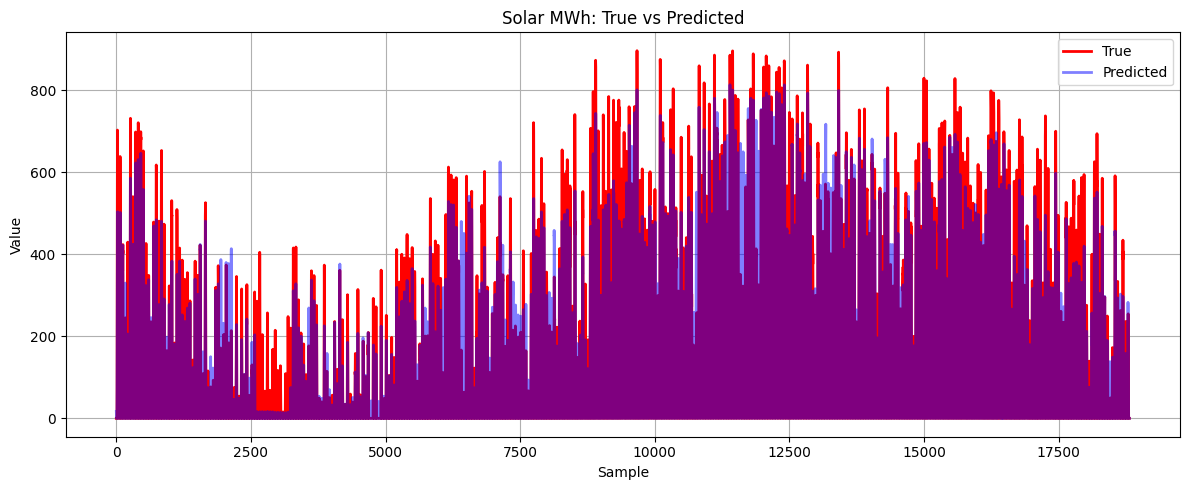


 WIND
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline]  (step 3 of 3) Processing imputer and scaler, total=   0.0s
Wind MAPE: 1.3754064393712806e+16


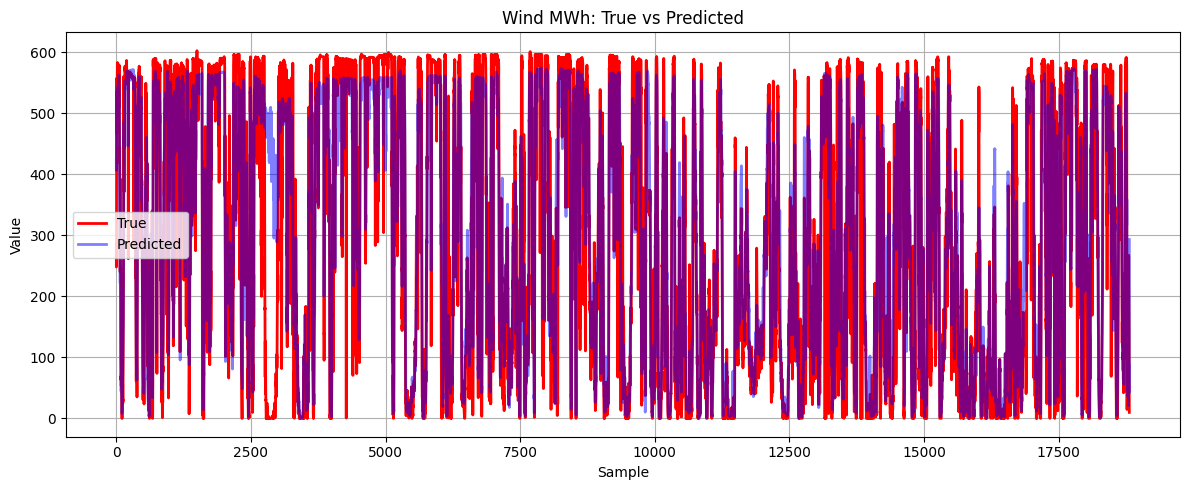

WPS MAPE: 8931135699852957.0


In [ ]:
# No quantile random forest

rf_solar = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n SOLAR")

solar_pipeline = Pipeline([
    ("preprocessing", feature_engineering_solar)])


X_train_solar_scaled = feature_engineering_solar.fit_transform(X_train_solar_mo, y_train_solar)
X_test_solar_scaled = feature_engineering_solar.transform(X_test_solar_mo)
rf_solar.fit(X_train_solar_scaled, y_train_solar)
y_pred_solar = rf_solar.predict(X_test_solar_scaled)

print("Solar MAPE:", mean_absolute_percentage_error(y_test_solar, y_pred_solar))

plt.figure(figsize=(12, 5))
plt.plot(y_test_solar.values, label='True', linewidth=2, color="red")
plt.plot(y_pred_solar, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Solar MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Wind model
rf_wind = RandomForestRegressor(
    n_estimators=500,
    max_depth=14,
    min_samples_split=10,    
    random_state=42,
    criterion='squared_error',
    n_jobs=-1
)

print("\n WIND")

wind_pipeline = Pipeline([
    ("preprocessing", feature_engineering_wind)])

X_train_wind_scaled = feature_engineering_wind.fit_transform(X_train_wind_mo, y_train_wind)
X_test_wind_scaled = feature_engineering_wind.transform(X_test_wind_mo)
rf_wind.fit(X_train_wind_scaled, y_train_wind)
y_pred_wind = rf_wind.predict(X_test_wind_scaled)

print("Wind MAPE:", mean_absolute_percentage_error(y_test_wind, y_pred_wind))

plt.figure(figsize=(12, 5))
plt.plot(y_test_wind.values, label='True', linewidth=2,  color="red")
plt.plot(y_pred_wind, label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Wind MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# combined
y_pred_wps = y_pred_wind + y_pred_solar

print("WPS MAPE:", mean_absolute_percentage_error(y_test_wps, y_pred_wps))


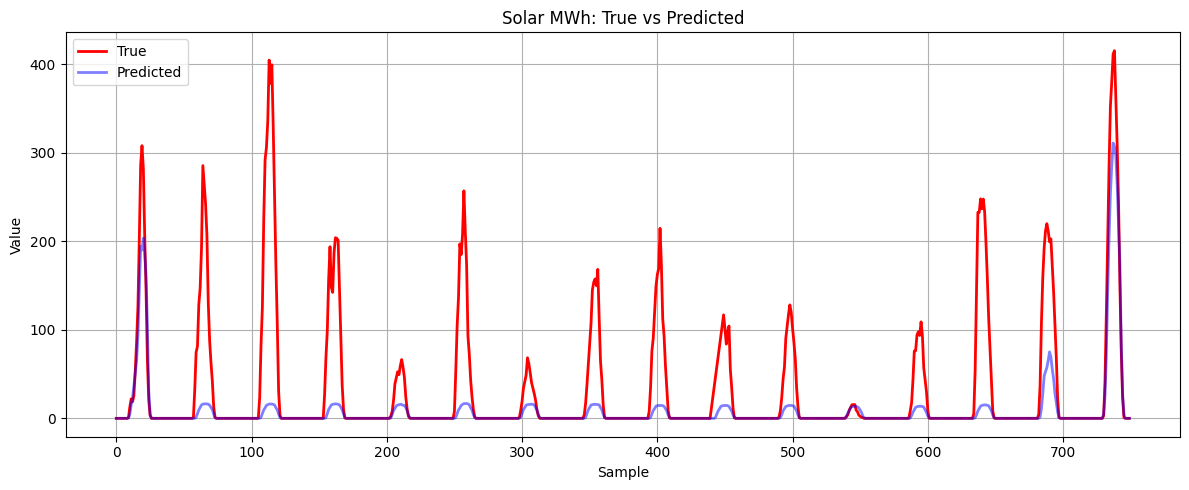

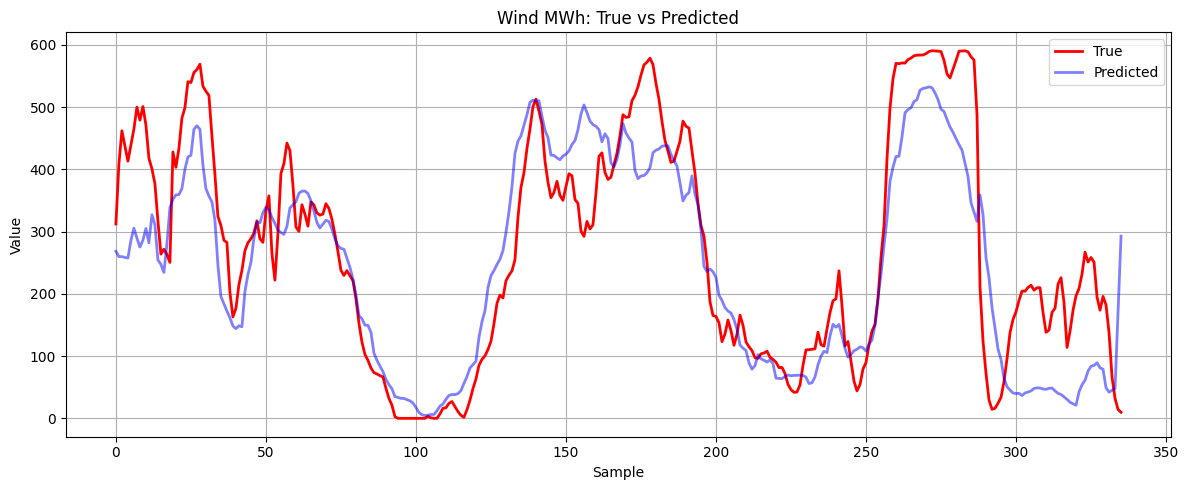

In [80]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_solar.values[2550:3300], label='True', linewidth=2, color="red")
plt.plot(y_pred_solar[2550:3300], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Solar MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#print(X_test_solar_scaled[2550:2600])
#print("-"*50)
#print(X_test_solar_scaled[2600:2650])

plt.figure(figsize=(12, 5))
plt.plot(y_test_wind.values[-336:], label='True', linewidth=2,  color="red")
plt.plot(y_pred_wind[-336:], label='Predicted', linewidth=2, color="blue", alpha=0.5)

plt.title("Wind MWh: True vs Predicted")
plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Well that went well a MAPE of hipoputumous gasizlion, it's due to that we hadle values close to zero. Regardless lets move on to quantiles

In [84]:
# quantiles withous using a class kill me

def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

def predict_quantiles(rf_model, X, quantiles=[0.1, 0.5, 0.9], verbose=False):
    all_tree_preds = np.stack([tree.predict(X) for tree in rf_model.estimators_], axis=1)
    results = {}
    for q in quantiles:
        if verbose:
            print(f"Calculating quantile: {q}")
        results[q] = np.percentile(all_tree_preds, q * 100, axis=1)
    return results

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

print("\nSolar")
quantile_preds_solar = predict_quantiles(rf_solar, X_test_solar_scaled, quantiles,verbose=True)
print("\nWind")
quantile_preds_wind = predict_quantiles(rf_wind, X_test_wind_scaled, quantiles,verbose=True)

wind_pinball_df = pd.DataFrame({
    "total_generation_MWh": y_test_wind.values
})
for q in range(10, 100, 10):
    wind_pinball_df[f"q{q}"] = quantile_preds_wind[q / 100]

wind_pinball = pinball_score(wind_pinball_df)
print("Wind Pinball Score:", wind_pinball)



Solar


c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature

Calculating quantile: 0.1
Calculating quantile: 0.2
Calculating quantile: 0.3
Calculating quantile: 0.4
Calculating quantile: 0.5
Calculating quantile: 0.6
Calculating quantile: 0.7
Calculating quantile: 0.8
Calculating quantile: 0.9

Wind


c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\KTH\Arskurs_4\EG2140 Computer Applications and Machine Learning in Electric Power Systems\EG2140-G_6\venv\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature

Calculating quantile: 0.1
Calculating quantile: 0.2
Calculating quantile: 0.3
Calculating quantile: 0.4
Calculating quantile: 0.5
Calculating quantile: 0.6
Calculating quantile: 0.7
Calculating quantile: 0.8
Calculating quantile: 0.9
Wind Pinball Score: 25.255062426821542


In [82]:
def run_forecast(X_train, y_train, X_test, feature_pipe, model, name, verbose=True):
    if verbose:
        print(f"\n{'='*50}")
        print(f" {name.upper()} FORECAST PROCESSING")
        print(f" Training samples: {len(X_train):,} | Test samples: {len(X_test):,}")
        start_time = time.time()
    
    # Feature engineering
    if verbose:
        print("\n [1/3] Feature Engineering")
        print(f"Transformer steps: {[name for name, _ in feature_pipe.steps]}")
    
    X_train_processed = feature_pipe.fit_transform(X_train, y_train)
    X_test_processed = feature_pipe.transform(X_test)
    
    if verbose:
        print(f" Features generated: {X_train_processed.shape[1]}")
        print(f" Time elapsed: {time.time()-start_time:.1f}s")
    
    # Model training
    if verbose:
        print("\n [2/3] Model Training")
        print(f"Model: {model.__class__.__name__}")
        print(f"Quantiles: {model.quantiles}")
    
    model.fit(X_train_processed, y_train)
    
    if verbose:
        print(f" Training completed")
        print(f" Time elapsed: {time.time()-start_time:.1f}s")
    
    # Prediction
    if verbose:
        print("\n [3/3] Generating Predictions")
    
    predictions = model.predict(X_test_processed)
    result_df = pd.DataFrame(
        predictions,
        columns=[f'q_{int(q*100)}' for q in model.quantiles],
        index=X_test.index
    )
    
    if verbose:
        print(f"Predictions generated")
        print(f"Total processing time: {time.time()-start_time:.1f}s")
        print(f"{'='*50}")
    
    return result_df

# Configure verbose output
VERBOSE = True

# 1. Solar Forecast
predictions_solar = run_forecast(
    X_train_solar_lf, y_train_solar, X_test_solar_lf,
    feature_engineering_solar, quantile_regressor, "Solar", VERBOSE
)

# 2. Wind Forecast
predictions_wind = run_forecast(
    X_train_wind_lf, y_train_wind, X_test_wind_lf,
    feature_engineering_solar, quantile_regressor, "Wind", VERBOSE
)

# 3. Combine Results
if VERBOSE:
    print("\n COMBINING SOLAR + WIND PREDICTIONS")
    combine_start = time.time()

total_predictions = predictions_solar.add(predictions_wind)
total_predictions['true_generation'] = y_test_wps

if VERBOSE:
    print(f"Combined predictions | Shape: {total_predictions.shape}")
    print(f"Time elapsed: {time.time()-combine_start:.1f}s")

# 4. Pinball Loss Calculation
if VERBOSE:
    print("\n CALCULATING PINBALL LOSS")
    pinball_start = time.time()

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pinball_scores = {}

for q in quantiles:
    q_label = f'q_{int(q*100)}'
    loss = pinball_loss(
        total_predictions['true_generation'],
        total_predictions[q_label],
        q
    )
    pinball_scores[q_label] = loss
    if VERBOSE:
        print(f"{q_label}: {loss:.4f}")

total_pinball = np.mean(list(pinball_scores.values()))

if VERBOSE:
    print(f"\n Total Pinball Score: {total_pinball:.4f}")
    print(f"Calculation time: {time.time()-pinball_start:.1f}s")

# 5. Visualization
if VERBOSE:
    print("\n GENERATING VISUALIZATION")
    plot_start = time.time()

plt.figure(figsize=(16, 8))
N = 150
index_slice = total_predictions.index[-N:]
true_values = total_predictions['true_generation'][-N:]
median_pred = total_predictions['q_50'][-N:]
q10_pred = total_predictions['q_10'][-N:]
q90_pred = total_predictions['q_90'][-N:]

plt.figure(figsize=(16, 8))
plt.plot(index_slice, true_values, label="True Generation", color="black", linewidth=2)
plt.plot(index_slice, median_pred, label="Predicted Median (q50)", color="royalblue", linestyle="--")
plt.fill_between(index_slice, q10_pred, q90_pred, color="skyblue", alpha=0.4, label="80% PI (q10-q90)")

plt.title(f"Wind + Solar Generation Forecast\nLast {N} Points | Total Pinball Score: {total_pinball:.4f}")
plt.xlabel("Timestamp")
plt.ylabel("Generation (MWh)")
plt.legend()
plt.grid(True)


if VERBOSE:
    print(f"Plot generation time: {time.time()-plot_start:.1f}s")
    print("\n FORECAST PROCESS COMPLETED")
plt.show()


 SOLAR FORECAST PROCESSING
 Training samples: 35,520 | Test samples: 18,816

 [1/3] Feature Engineering
Transformer steps: ['cyclic', 'lag', 'imputer_and_scaler']
[Pipeline] ............ (step 1 of 3) Processing cyclic, total=   0.0s
[Pipeline] ............... (step 2 of 3) Processing lag, total=   0.0s
[Pipeline]  (step 3 of 3) Processing imputer_and_scaler, total=   0.1s
 Features generated: 36
 Time elapsed: 0.2s

 [2/3] Model Training
Model: RandomForestQuantileRegressor
Quantiles: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


KeyboardInterrupt: 

In [ ]:
test =X_train_solar_mo["valid_datetime"]
print(test)

0            0
1            1
2            2
3            3
4            4
         ...  
35515    35515
35516    35516
35517    35517
35518    35518
35519    35519
Name: valid_datetime, Length: 35520, dtype: int64
